<h2>Loan Defaulter Project (Dealing with Missing Values):</h2>
<p>In this Data Science Project, I would be <strong>predicting whether a customer should be approved for the loan or not. </strong> We would be simply deploying this model on Heroku and then creating a Web and Mobile Application for Bank Managers so that they can have a look at those people who should be approved for loan.</p>

In [1]:
# Importing numpy, pandas, matplotlib and seaborn :
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for handling the warnings:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
# reading original data:
orig_data = pd.read_csv('loan_train.csv')
orig_data = orig_data.drop('Loan_ID', axis=1)
orig_data.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [3]:
# columns name of orig_data:
feats_orig = list(orig_data.columns)
cat_feats_orig = []
num_feats_orig = []

# distincting features:
for feature in feats_orig:
    if orig_data[feature].nunique() > 10:
        num_feats_orig.append(feature)
    else:
        cat_feats_orig.append(feature)

print('Categorical Feature: ', cat_feats_orig, end='\n\n')
print('Numerical Features: ', num_feats_orig)

Categorical Feature:  ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']

Numerical Features:  ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']


In [4]:
# numerical data:
orig_data[num_feats_orig].head()

,ApplicantIncome,CoapplicantIncome,LoanAmount
0,5849,0.0,NaN
1,4583,1508.0,128.0
2,3000,0.0,66.0
3,2583,2358.0,120.0
4,6000,0.0,141.0


In [5]:
# categotical data:
orig_data[cat_feats_orig].head()

,Gender,Married,Dependents,Education,Self_Employed,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,360.0,1.0,Urban,Y


<h2>Inspecting Missing Values:</h2>

In [6]:
# Number of missing values in each of the feature:
temp_data = orig_data.copy() # creating a copy of original data
temp_data.isnull().sum() # creates a Pandas Series

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [7]:
# creating data which does not contain any null values:
no_null_data = temp_data.dropna()
print('Observations in no_null_data -->', len(no_null_data))

Observations in no_null_data --> 480


In [8]:
# percentage of data removed from temp_data to create no_null_data:
print('Percentage of data removed: ', (1-(len(no_null_data)/len(temp_data)))*100, '%')

Percentage of data removed:  21.824104234527685 %


In [26]:
no_null_data.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [28]:
print('total number of rows in Original Data -->', len(orig_data))

total number of rows in Original Data --> 614


In [29]:
print('total number of rows in reference Data -->', len(no_null_data))

total number of rows in reference Data --> 480


<h3>Inspection of Missing Values:</h3>
<p>
<ol>
    <li>Most of the features seems to have missing values but the number of missing values is not that high.</li>
    <li>We would be using <code>no_null_data</code> for extracting insights and relationship among different features. These relationships among different features could be used for dealing with the missing values in a proper manner.</li>
    <li>Only 5 features are there which do not have any missing values within them.</li>
    <li>The aim to deal with missing values is start with the feature which has the least number of missing values and then go till the feature which has the highest number of missing values.</li>
      </ol>
</p>

In [14]:
num_feats_orig

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

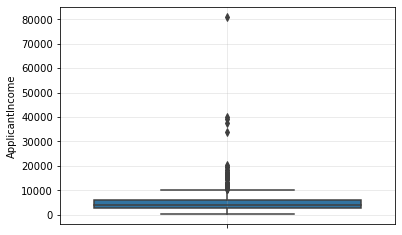

In [17]:
# inspect boxplot of a numerical feat:
sns.boxplot(y="ApplicantIncome", data=no_null_data)
plt.grid(True, alpha=0.3)

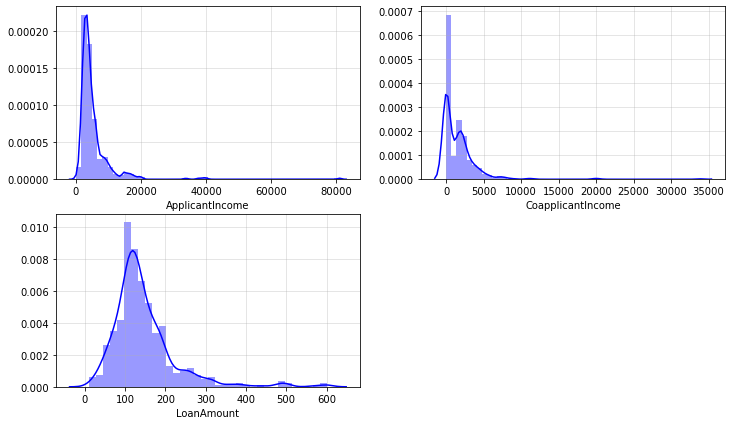

In [18]:
# distribution of numerical features:
plt.figure(figsize=(12, 7))
k = 1
for num_feat in num_feats_orig:
    plt.subplot(2, 2, k);
    sns.distplot(no_null_data[num_feat]+1, color='blue')
    plt.grid(True, alpha=0.4)
    k +=1

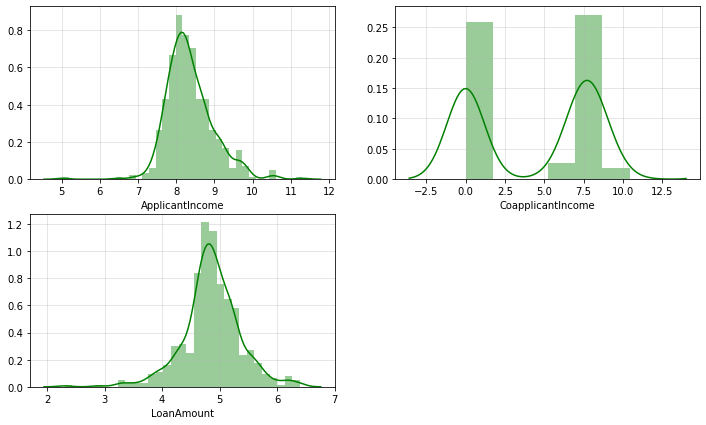

In [19]:
# log transformation of numerical features:
plt.figure(figsize=(12, 7))
k = 1
for num_feat in num_feats_orig:
    plt.subplot(2, 2, k);
    sns.distplot(np.log(no_null_data[num_feat]+1), color='green')
    plt.grid(True, alpha=0.4)
    k +=1

<h3>Chi-Square Test of Independence and One-Way ANOVA Test:</h3>

In [11]:
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

# one-way anova test which finds the significant numerical features wrt a categorical feature:
def one_way_anova(data, cur_cat_feat, numerical_feats):
    categories = list(data[cur_cat_feat].unique())
    anova_result = []
    
    for each_num_feat in numerical_feats:
        list_data_categories = [data[data[cur_cat_feat]==category][each_num_feat] for category in categories]
        p_value = f_oneway(*list_data_categories)[1]
        
        # significant feature only:
        if p_value<0.05:
            anova_result.append((each_num_feat, p_value))
        
    result_df = pd.DataFrame(anova_result, columns=['Significant Features', 'P-Values'])
    return result_df

# computes the features depending significantly on a particular feature:
def chi2_test_of_indep(correct_data, feat_wrt, all_cat_feats, all_num_feats):
    results_ = []
    num_categories = correct_data[feat_wrt].nunique()
    print('Chi-square Test of Independence is computed for --> ', feat_wrt)
    for categorical_feat in all_cat_feats:
        if categorical_feat != feat_wrt:
            cont_table = pd.pivot_table(correct_data, 
                                    columns=[feat_wrt], 
                                    index=[categorical_feat], 
                                    aggfunc=len)
            
            final_cont_table = cont_table.iloc[:, :num_categories]
            p_value = chi2_contingency(final_cont_table)[1]
            
            # significant features dependence:
            if p_value<=0.05:
                results_.append((categorical_feat, p_value))
                
        else:
            continue
            
    anova_result_table = one_way_anova(correct_data, feat_wrt, all_num_feats)
    test_of_indep_df = pd.DataFrame(results_, columns=['Significant Features', 'P-Values'])
    stats_test_table = pd.concat([anova_result_table, test_of_indep_df], axis=0)
    return stats_test_table

# looking missing values of a particular feature:
def look_up_missing_values_data(test_of_indep_table, feat_wrt):
    significant_feats = list(test_of_indep_table['Significant Features'])
    missing_values_data = temp_data[temp_data[feat_wrt].isnull()][significant_feats]
    return missing_values_data

# ratio of categories of a particular categprical feature:
def ratio_of_categories(data, feat_wrt):
    print('Analysis of: ', feat_wrt)
    categories = list(data[feat_wrt].unique())
    for category in categories:
        print('Proportion of {} --> {}%'.format(category, (len(data[data[feat_wrt]==category])/len(data))*100))
    sns.countplot(feat_wrt, data=data)
    plt.show()

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# creating the Logistic Regression or Softmax Regression model to deal with the missing values
# of the categorical feature:

# remember data = copy of no_null_data:
def encoding_categorical_features(train_data, test_data, test_of_indep_table, to_drop_list_features=None):
    final_significant_feats = list(test_of_indep_table['Significant Features'])
    
    if len(to_drop_list_features)>0:
        final_significant_feats = list(set(final_significant_feats).symmetric_difference(set(to_drop_list_features)))
    
    inter_data_train = train_data[final_significant_feats] # interested training data
    inter_data_test = test_data[final_significant_feats] # interested test data
    
    # iterating over the categories of each categorical feature:
    for sig_feat in final_significant_feats:
        if inter_data_train[sig_feat].nunique() > 5:
            # a numerical feature:
            # scale the numerical features to the same range using standardization(mean=0 and std_dev=1):
            mean = np.mean(inter_data_train[sig_feat])
            median = np.mean(inter_data_train[sig_feat])
            std_dev = np.std(inter_data_train[sig_feat])
            
            # if any missing value is present for a numerical feature:
            inter_data_train[sig_feat] = np.where(inter_data_train[sig_feat].isnull(), median, inter_data_train[sig_feat])
            inter_data_test[sig_feat] = np.where(inter_data_test[sig_feat].isnull(), median, inter_data_test[sig_feat])
            
            # standardization:
            inter_data_train[sig_feat] = (inter_data_train[sig_feat]-mean)/std_dev
            inter_data_test[sig_feat] = (inter_data_test[sig_feat]-mean)/std_dev
            
        else:
            # a categorical feature:
            # iterate over each category of the significant categorical feature:
            for sig_cat_category in inter_data_train[sig_feat].unique():
                inter_data_train[sig_feat + '_' + sig_cat_category] = np.where(inter_data_train[sig_feat]==sig_cat_category, 1, 0)
                inter_data_test[sig_feat + '_' + sig_cat_category] = np.where(inter_data_test[sig_feat]==sig_cat_category, 1, 0)
                
            # removing the categorical feature once encoded:
            inter_data_train = inter_data_train.drop([sig_feat], axis=1)
            inter_data_test = inter_data_test.drop([sig_feat], axis=1)
            
#     print('Final Training Data: \n', inter_data_train)
#     print('Final Test Data: \n', inter_data_test)
    return inter_data_train, inter_data_test 

# modelling the data to deal with the missing values:
def split_data(full_training_data, encoded_target_data):
     # creating training and validation data:
    x_train = full_training_data[:450]
    y_train = encoded_target_data[:450]
    
    x_val = full_training_data[450:]
    y_val = encoded_target_data[450:]
    return x_train, y_train, x_val, y_val

# full_data = copy of no_null_data:
def predicting_missing_values(full_training_data, target_feature, full_data, test_data, reg_param):
    if full_data[target_feature].nunique()<5:
        # a categorical dependent feature
        
        categories = list(full_data[target_feature].unique())
        encoded_target_data = full_data[target_feature].map({categories[i]:i for i in range(len(categories))}) # dict comprehension
        x_train, y_train, x_val, y_val = split_data(full_training_data, encoded_target_data)
        
        # training model:
        if len(categories) == 2:
            # train logistic regression
            log_reg_clf = LogisticRegression(C=reg_param)
            final_model = evaluating_model_perf_clf(x_train, y_train, x_val, y_val, log_reg_clf)
            missing_values = final_model.predict(test_data)
            return missing_values, categories

        else:
            # train softmax regression
            softmax_reg_clf = LogisticRegression(C=reg_param, multi_class='multinomial')
            final_model = evaluating_model_perf_clf(x_train, y_train, x_val, y_val, softmax_reg_clf)
            missing_values = final_model.predict(test_data)
            return missing_values, categories
        
    else:
        # a numerical dependent feature: no need to standardize it:
        encoded_target_data = full_data[target_feature]
        x_train, y_train, x_val, y_val = split_data(full_training_data, encoded_target_data)
        final_model = train_linear_regression_model(x_train, y_train, x_val, y_val)
        missing_values = final_model.predict(test_data)
        return missing_values

# evaluating model's performance as well:
def evaluating_model_perf_clf(x_train, y_train, x_val, y_val, model):
#     training_error = []
#     validation_error = []
    
    # training the model on data which increases by 1 factor:
#     for row_number in range(100, len(x_train)+1):
#         model.fit(x_train[:row_number], y_train[:row_number])
        
#         # make predictions on training data:
#         train_pred = model.predict(x_train[:row_number])
#         cur_train_error = log_loss(y_train[:row_number], train_pred)
#         training_error.append(cur_train_error)
        
#         # make predictions on validation data:
#         val_pred = model.predict(x_val)
#         cur_val_error = log_loss(y_val, val_pred)
#         validation_error.append(cur_val_error)
        
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    val_pred = model.predict(x_val)
    
    # evaluation metrics for training
    train_prec = precision_score(y_train, train_pred, average=None)
    train_recall = recall_score(y_train, train_pred,  average=None)
    train_f1 = f1_score(y_train, train_pred,  average=None)
    train_acc = accuracy_score(y_train, train_pred)
    
    # evaluation metrics for validation:
    val_prec = precision_score(y_val, val_pred,  average=None)
    val_recall = recall_score(y_val, val_pred,  average=None)
    val_f1 = f1_score(y_val, val_pred,  average=None)
    val_acc = accuracy_score(y_val, val_pred)
    
    table_data = [(train_prec, val_prec), (train_recall, val_recall), (train_f1, val_f1), (train_acc, val_acc)]
    results_table = pd.DataFrame(table_data, 
                 columns=['Training Eval Metrics', 'Validation Eval Metrics'], 
                 index=['Precision', 'Recall', 'F1-Score', 'Accuracy'])
    
    print('\n Evaluation Table: \n')
    print(results_table)
    
#     # plotting the training and validation error:
#     plt.figure(figsize=(12, 8))
#     plt.plot(np.arange(len(training_error)), training_error, 'r-o', label='Training Error')
#     plt.plot(np.arange(len(validation_error)), validation_error, 'g-^', label='Validation Error')
#     plt.xlabel('Number of Iterations', fontsize=13)
#     plt.ylabel('Cost function', fontsize=13)
#     plt.title('Evaluating Model', fontsize=15)
#     plt.legend()
#     plt.grid(True, alpha=0.4)
    
    return model    

In [13]:
# adding the missing values to the data:
def attach_missing_values(target_feature, missing_values_to_add, temp_data, categories=None):
    test_data = temp_data[temp_data[target_feature].isnull()]
    temp_new_data = temp_data.drop(index=list(test_data.index), axis=0)
    test_data[target_feature] = missing_values_to_add
    if categories:
        test_data[target_feature] = test_data[target_feature].map({i:categories[i] for i in range(len(categories))})
    
    print('\nData after dealing with Missing Values: \n', test_data[target_feature])
    final_temp_data = pd.concat([temp_new_data, test_data], axis=0)
    return final_temp_data

# combining all of the above functions in a single function:
def analysis_and_predicting_missing_values(data, target_feature, cat_feats_orig, data_to_add_missing_values_pred, reg_param=1.0):
    # analysis of target feature:
    ratio_of_categories(data, target_feature)
    
    # chi2 test of independece:
    test_of_indep_table = chi2_test_of_indep(data, target_feature, cat_feats_orig, num_feats_orig)
    print('Result of Chisquare Test of independence', end='\n\n')
    print(test_of_indep_table)
    
    # loooking up data for which target feature has missing value:
    init_test_data = look_up_missing_values_data(test_of_indep_table, target_feature)
    print('Result of Test Data:', end='\n\n')
    print(init_test_data, end='\n\n')
    
    # encoding categorical data:
    to_drop_feats = input('Enter the feature or features to drop: ').split()
    print('Feature to Remove: ', to_drop_feats)
    (final_train_data, final_test_data) = encoding_categorical_features(data, init_test_data, test_of_indep_table, to_drop_list_features=to_drop_feats)
    
    # predicting missing values by creating a model:
    missing_values, categories = predicting_missing_values(final_train_data, target_feature, data, final_test_data, reg_param=reg_param)
    miss_val_dealt_data = attach_missing_values(target_feature, list(missing_values), categories=categories, temp_data=data_to_add_missing_values_pred)
    return miss_val_dealt_data

<h3>How can we use above functions?</h3>
<p>
<ol>
    <li>Start with analyzing the ratio of categories using: <code>ratio_of_categories()</code></li>
    <li>Use <code>chi2_test_of_indep()</code> to compute the features which are significantly dependent on the the feature whose missing value is to be computed.</li>
    <li>Use <code>look_up_missing_value()</code> to have a look at what other features have missing values along with the feature whose missing value is to be computed. Result of this function will be used in choosing the final features to create a model.</li>
    <li>We can generate test data for a feature whose missing value is to be computed using <code>generate_test_data_for_feature()</code> function.</li>
    <li>Now, we encode the categorical features of train and test data using <code>encoding_categorical_features()</code> function.</li>
    <li>Finally we use <code>predicting_missing_values()</code> function to predict the missing value based upon the trained model. This function in turn calls <code>evaluating_model_perf()</code> which helps us to have a look at the training an validation errors.</li>
    <li><code>analysing_and_predicting_missing_values()</code> function combines all of the functions above and shows result for each of the categorical feature's analysis</li>
    <li><code>attach_missing_values()</code> is a function which adds the predicted values by the model to the data and concatenates the data. </li>    
    </ol>
</p>

<h4>Missing Values for "Loan_Amount_Term":</h4>

Analysis of:  Loan_Amount_Term
Proportion of 360.0 --> 85.625%
Proportion of 120.0 --> 0.625%
Proportion of 180.0 --> 7.5%
Proportion of 60.0 --> 0.4166666666666667%
Proportion of 300.0 --> 1.875%
Proportion of 480.0 --> 2.5%
Proportion of 240.0 --> 0.4166666666666667%
Proportion of 36.0 --> 0.4166666666666667%
Proportion of 84.0 --> 0.625%


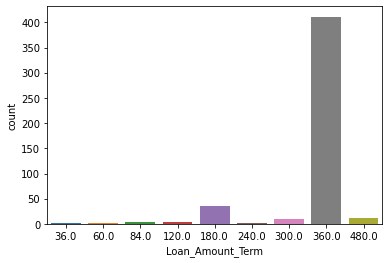


Data after dealing with Missing Values: 
 19     360.0
36     360.0
44     360.0
45     360.0
73     360.0
112    360.0
165    360.0
197    360.0
223    360.0
232    360.0
335    360.0
367    360.0
421    360.0
423    360.0
Name: Loan_Amount_Term, dtype: float64


In [14]:
no_null_copy_data = no_null_data.copy()
ratio_of_categories(no_null_copy_data, 'Loan_Amount_Term')
num_missing_values = temp_data['Loan_Amount_Term'].isnull().sum()

# Since most of the 86% of "Loan_Amount_Term" contains 360.0, thus replace 360.0 for all of its missing values.
missing_values = [360.0]*num_missing_values
temp_data = attach_missing_values("Loan_Amount_Term", missing_values, temp_data)

In [15]:
temp_data.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term      0
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

<h4>Missing Values of 'Married':</h4>

Analysis of:  Married
Proportion of Yes --> 64.79166666666667%
Proportion of No --> 35.208333333333336%


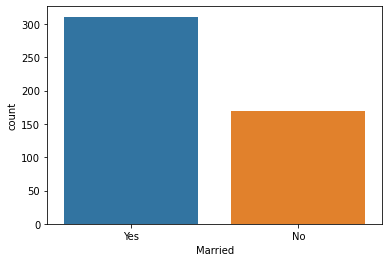

Chi-square Test of Independence is computed for -->  Married
Result of Chisquare Test of independence

  Significant Features      P-Values
0    CoapplicantIncome  2.409273e-02
1           LoanAmount  5.279412e-05
0               Gender  5.038824e-14
1           Dependents  7.368576e-18
2          Loan_Status  1.840546e-02
Result of Test Data:

     CoapplicantIncome  LoanAmount  Gender Dependents Loan_Status
104              754.0       160.0    Male        NaN           Y
228                0.0       158.0    Male        NaN           Y
435                0.0         NaN  Female        NaN           Y

Enter the feature or features to drop: Dependents
Feature to Remove:  ['Dependents']

 Evaluation Table: 

                               Training Eval Metrics  \
Precision   [0.7181571815718157, 0.7160493827160493]   
Recall     [0.9201388888888888, 0.35802469135802467]   
F1-Score    [0.8066971080669711, 0.4773662551440329]   
Accuracy                                    0.717778   



In [16]:
# dealing with the missing values of Married:
temp_data = analysis_and_predicting_missing_values(no_null_copy_data, 'Married', cat_feats_orig, temp_data)

In [17]:
# no missing values for Married:
temp_data['Married'].isnull().sum()

0

<h4>Missing Values of Dependents:</h4>

Analysis of:  Dependents
Proportion of 1 --> 16.666666666666664%
Proportion of 0 --> 57.08333333333333%
Proportion of 2 --> 17.708333333333336%
Proportion of 3+ --> 8.541666666666666%


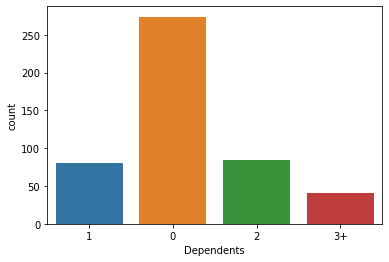

Chi-square Test of Independence is computed for -->  Dependents
Result of Chisquare Test of independence

  Significant Features      P-Values
0      ApplicantIncome  2.453255e-03
1           LoanAmount  6.568302e-04
0               Gender  2.623355e-05
1              Married  7.368576e-18
Result of Test Data:

     ApplicantIncome  LoanAmount  Gender Married
102            13650         NaN    Male     Yes
120             5667       180.0    Male     Yes
226             4735       138.0    Male     Yes
293             5417       143.0  Female      No
301             2875       105.0    Male     Yes
332             2833        71.0    Male      No
346             3523       152.0    Male     Yes
355             3813       116.0  Female      No
517             3074       123.0    Male     Yes
571             5116       165.0    Male     Yes
597             2987        88.0    Male      No
335             5503        70.0    Male     Yes
104             3816       160.0    Male     Yes
2

In [18]:
# dealing with the missing values of Dependents:
temp_data = analysis_and_predicting_missing_values(no_null_copy_data, 'Dependents', cat_feats_orig, temp_data)

In [19]:
# no missing values for "Dependets":
temp_data['Dependents'].isnull().sum()

0

<h4>Missing Values of 'Gender':</h4>

Analysis of:  Gender
Proportion of Male --> 82.08333333333333%
Proportion of Female --> 17.916666666666668%


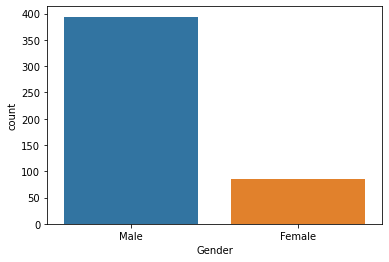

Chi-square Test of Independence is computed for -->  Gender
Result of Chisquare Test of independence

  Significant Features      P-Values
0    CoapplicantIncome  5.954139e-04
1           LoanAmount  3.015042e-02
0              Married  5.038824e-14
1           Dependents  2.623355e-05
Result of Test Data:

     CoapplicantIncome  LoanAmount Married Dependents
23              1917.0       112.0     Yes          2
126                0.0       370.0     Yes         3+
171                0.0       700.0     Yes         3+
188             5296.0       168.0     Yes          0
314             1843.0       159.0     Yes          0
334             1833.0       182.0     Yes          1
460             4083.0       160.0     Yes          0
467                0.0       110.0     Yes          0
477             1872.0       132.0     Yes          2
507                0.0        96.0      No          0
576             2210.0       136.0     Yes          0
588                0.0        94.0      No 

In [20]:
# missing values of Gender:
temp_data = analysis_and_predicting_missing_values(no_null_copy_data, 'Gender', cat_feats_orig, temp_data)

In [21]:
# no missing values for "Gender":
temp_data.isnull().sum()

Gender                0
Married               0
Dependents            0
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term      0
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

<h4>Missing Values of "Self-Employed":</h4>

Analysis of:  Self_Employed
Proportion of No --> 86.25%
Proportion of Yes --> 13.750000000000002%


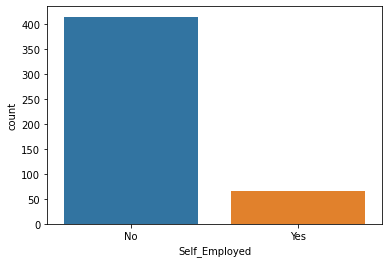

Chi-square Test of Independence is computed for -->  Self_Employed
Result of Chisquare Test of independence

  Significant Features  P-Values
0      ApplicantIncome  0.000170
1           LoanAmount  0.008283
Result of Test Data:

     ApplicantIncome  LoanAmount
11              2500       109.0
24              3717       151.0
29              3750       120.0
30              4166       201.0
95              6782         NaN
107             7333       120.0
111             2929       139.0
114             5050       118.0
158             2980       120.0
170             1820        95.0
218             5000        72.0
231             3716        42.0
236             5746       255.0
268             3418       135.0
295             4416       110.0
333            63337       490.0
336             5250       160.0
344             2583       125.0
374             2764       110.0
380             3333       128.0
385             3667       113.0
411             6256       160.0
432        

In [22]:
# missing values of self-employed:
temp_data = analysis_and_predicting_missing_values(no_null_copy_data, 'Self_Employed', cat_feats_orig, temp_data)

In [23]:
# no missing values for "self-employed":
temp_data.isnull().sum()

Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term      0
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

<h4>Missing Values of "Credit-History":</h4>

Analysis of:  Credit_History
Proportion of 1.0 --> 85.41666666666666%
Proportion of 0.0 --> 14.583333333333334%


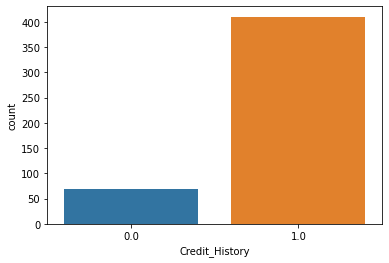

Chi-square Test of Independence is computed for -->  Credit_History
Result of Chisquare Test of independence

  Significant Features      P-Values
0          Loan_Status  2.135982e-30
Result of Test Data:

    Loan_Status
16            Y
42            Y
79            Y
83            N
86            Y
117           Y
125           Y
129           N
130           Y
156           Y
181           N
187           Y
198           Y
219           Y
237           Y
259           N
260           Y
279           Y
309           Y
313           Y
317           Y
318           Y
323           Y
348           Y
363           Y
377           Y
392           Y
395           Y
444           Y
449           N
451           Y
473           Y
490           Y
491           Y
497           Y
503           N
506           Y
530           Y
533           N
544           Y
556           Y
565           Y
583           N
460           Y
24            N
30            N
95            N
236           N
411       

In [24]:
# missing values of credit-history:
temp_data = analysis_and_predicting_missing_values(no_null_copy_data, 'Credit_History', cat_feats_orig, temp_data)

In [25]:
# no missing values for 'Credit History':
temp_data.isnull().sum()

Gender                0
Married               0
Dependents            0
Education             0
Self_Employed         0
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term      0
Credit_History        0
Property_Area         0
Loan_Status           0
dtype: int64

In [26]:
cat_feats_orig

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Loan_Amount_Term',
 'Credit_History',
 'Property_Area',
 'Loan_Status']

<h3>Dealing With Missing Values of Numerical Feature:</h3>

In [20]:
# used for finding the significant features which explain the variance of the numerical features:
def one_way_anova_num(data, cur_num_feat, categorical_feats):
    anova_result = []
    
    for cur_cat_feat in categorical_feats:
        categories = list(data[cur_cat_feat].unique())
        list_data_categories = [data[data[cur_cat_feat]==category][cur_num_feat] for category in categories]
        p_value = f_oneway(*list_data_categories)[1]
        
        # significant feature only:
        if p_value<0.05:
            anova_result.append((cur_cat_feat, p_value))
        
    result_df = pd.DataFrame(anova_result, columns=['Significant Features', 'P-Values'])
    return result_df

# Scatter Plots to understand the relationship between 2 numerical feats:
def scatter_plots(data, num_feature, num_feats=num_feats_orig):
    plt.figure(figsize=(14, 5))
    k=1
    for num_feat in num_feats_orig:
        if (num_feat!=num_feature):
            plt.subplot(1, 3, k);
            plt.scatter(data[num_feature], data[num_feat])
            plt.xlabel(num_feature)
            plt.ylabel(num_feat)
            plt.grid(True, alpha=0.4)
            k +=1
        else:
            continue

In [21]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

def encoding_feats(train_data, test_data, test_of_indep_table, num_feature):
    significant_feats = list(test_of_indep_table['Significant Features'])
#     print(significant_feats)
    corr_num_feats = train_data.corr()
    feats = list(corr_num_feats.index)
    arr_ = list(corr_num_feats[num_feature].values)
    feats_to_add = []
    
    for idx in range(len(feats)):
        if (arr_[idx]>0.1):
            if (arr_[idx]!=1):
                feats_to_add.append(feats[idx])
            else: 
                print('The feature is nothin but a target feature itself')
#     print(feats_to_add)
    final_significant_feats = significant_feats+feats_to_add
    print('Final Selected Important Features: ', final_significant_feats)
 
    inter_data_train = train_data[final_significant_feats] # interested training data
    inter_data_test = test_data[final_significant_feats] # interested test data
    
    # iterating over the categories of each categorical feature:
    for sig_feat in final_significant_feats:
        if inter_data_train[sig_feat].nunique() > 5:
            # a numerical feature:
            # scale the numerical features to the same range using standardization(mean=0 and std_dev=1):
            mean = np.mean(inter_data_train[sig_feat])
            median = np.mean(inter_data_train[sig_feat])
            std_dev = np.std(inter_data_train[sig_feat])
            
            # if any missing value is present for a numerical feature:
            inter_data_train[sig_feat] = np.where(inter_data_train[sig_feat].isnull(), median, inter_data_train[sig_feat])
            inter_data_test[sig_feat] = np.where(inter_data_test[sig_feat].isnull(), median, inter_data_test[sig_feat])
            
            # standardization:
            inter_data_train[sig_feat] = (inter_data_train[sig_feat]-mean)/std_dev
            inter_data_test[sig_feat] = (inter_data_test[sig_feat]-mean)/std_dev
            
        else:
            # a categorical feature:
            # iterate over each category of the significant categorical feature:
            for sig_cat_category in inter_data_train[sig_feat].unique():
                inter_data_train[sig_feat + '_' + sig_cat_category] = np.where(inter_data_train[sig_feat]==sig_cat_category, 1, 0)
                inter_data_test[sig_feat + '_' + sig_cat_category] = np.where(inter_data_test[sig_feat]==sig_cat_category, 1, 0)
                
            # removing the categorical feature once encoded:
            inter_data_train = inter_data_train.drop([sig_feat], axis=1)
            inter_data_test = inter_data_test.drop([sig_feat], axis=1)
            
#     print('Final Training Data: \n', inter_data_train)
#     print('Final Test Data: \n', inter_data_test)
    return inter_data_train, inter_data_test 

# compute rmse on training and validation data:
def rmse_error(actual_val, pred_val):
    rmse = np.sqrt(np.sum((actual_val-pred_val)**2)/len(actual_val))
    return rmse
    
# evaluating regression model by checking the assumptions:
def evaluating_reg_model(actual_val, pred_val):
    residuals = actual_val-pred_val # vectorization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
    
    # assumptions of Linear Regression:
    # Linearity:
    ax1.scatter(actual_val, pred_val, color='darkred')
    ax1.plot([min(actual_val), max(actual_val)], [min(pred_val), max(pred_val)], 'b-')
    ax1.grid(True, alpha=0.4)
    ax1.set_xlabel('Actual Target Values', fontsize=10)
    ax1.set_ylabel('Predicted Target Values', fontsize=10)
    ax1.set_title('Linearity Property', fontsize=12)
    
    # Homoscedasticity:
    ax2.scatter(pred_val,  residuals, color='darkred')
    ax2.hlines(y=0, xmin=min(pred_val), xmax=max(pred_val), linewidth=2, color='blue')
    ax2.grid(True, alpha=0.4)
    ax2.set_xlabel('Predicted Values', fontsize=10)
    ax2.set_ylabel('Residuals', fontsize=10)
    ax2.set_title('Homoscedasticity', fontsize=12)
    
    # Standardized Residuals:
    sns.distplot(residuals, color='darkred', ax=ax3)
    ax3.grid(True, alpha=0.4)
    ax3.set_xlabel('Residuals', fontsize=10)
    ax3.set_title('Standardized Residuals', fontsize=12)
    
    # Autocorrelation Function:
    plot_acf(residuals, ax=ax4, color='red')
    ax4.grid(True, alpha=0.4)
    ax4.set_xlabel('Residuals', fontsize=10)
    ax4.set_title('Autocorrelation Function', fontsize=12)

# training a linear regression model:
def train_linear_regression_model(x_train, y_train, x_val, y_val):
    model = sm.OLS(y_train, x_train)
    result = model.fit()
    print(result.summary())
    
    train_pred = result.predict(x_train)
    val_pred = result.predict(x_val)
    
    # trained model evaluation:
    print('Evaluating The Regression Model on Training Data:')
    evaluating_reg_model(y_train, train_pred)
    
#     # evaluating validation model:
#     evaluating_reg_model(y_val, val_pred)
    
    train_rmse = rmse_error(y_train, train_pred)
    val_rmse = rmse_error(y_val, val_pred)
    
    print('Performance of Model: \n',)
    print('Training RMSE -->', train_rmse)
    print('Validation RMSE -->', val_rmse)
    return result
    
# process of training regression model for Numerical Feature missing values:
def analysing_and_predicting_missing_num_values(no_null_copy_data, target_num_feature, data_to_add_missing_values, reg_params=1):
    anova_result = one_way_anova_num(no_null_copy_data, target_num_feature, cat_feats_orig)
    init_test_data = temp_data[temp_data[target_num_feature].isnull()]
    train_data, test_data = encoding_feats(no_null_copy_data, init_test_data, anova_result, target_num_feature)
    missing_values_to_add = predicting_missing_values(train_data, target_num_feature, no_null_copy_data, test_data, reg_param=reg_params)
    final_data = attach_missing_values(target_num_feature, missing_values_to_add, temp_data=data_to_add_missing_values)    
    return final_data

<h4>Missing Values of "LoanAmount":</h4>

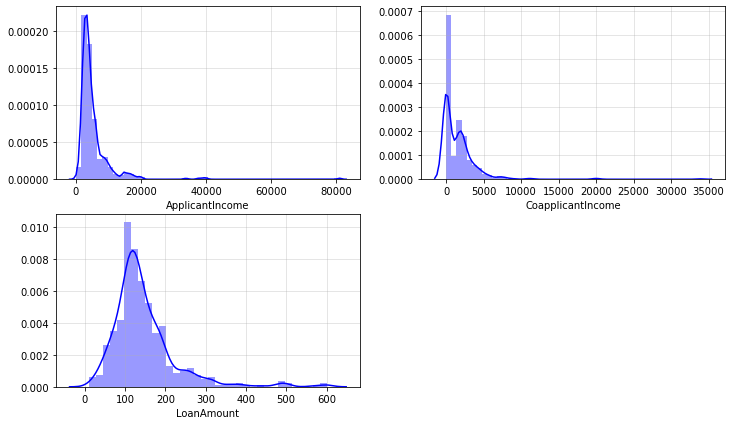

In [22]:
# distribution of numerical features:
plt.figure(figsize=(12, 7))
k = 1
for num_feat in num_feats_orig:
    plt.subplot(2, 2, k);
    sns.distplot(no_null_data[num_feat]+1, color='blue')
    plt.grid(True, alpha=0.4)
    k +=1

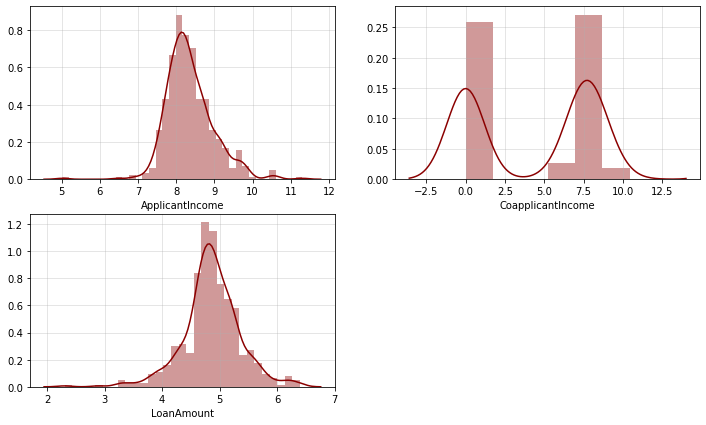

In [23]:
# logarithmic transformation of numerical features:
plt.figure(figsize=(12, 7))
k = 1
for num_feat in num_feats_orig:
    plt.subplot(2, 2, k);
    sns.distplot(np.log(no_null_data[num_feat]+1), color='darkred')
    plt.grid(True, alpha=0.4)
    k +=1

<p>Logarithmic Transformation works really well with <strong>'ApplicantIncome' and 'LoanAmount'.</strong></p>

In [25]:
# significant categorical features which explain the variance of 'LoanAmount':
loan_amount_1way_table = one_way_anova_num(no_null_data, 'LoanAmount', cat_feats_orig)
loan_amount_1way_table

NameError: name 'f_oneway' is not defined

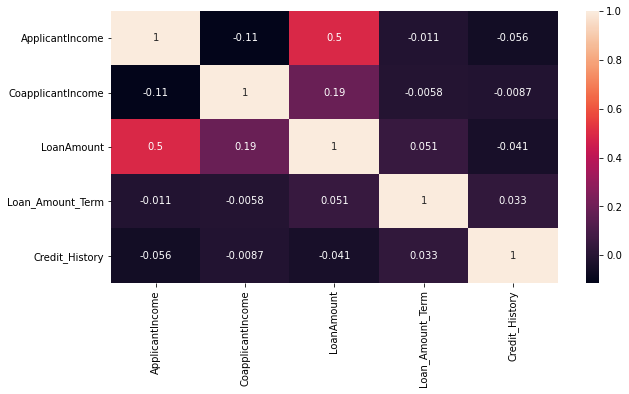

In [32]:
# features having high correlation with "LoanAmount":
plt.figure(figsize=(10, 5))
corr_ = no_null_copy_data.corr()
sns.heatmap(corr_, annot=True)

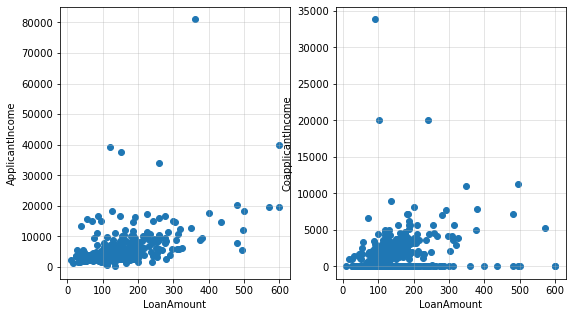

In [33]:
# Scatter Plots to understand the relationship between the 'LoanAmount' and other num feats:
scatter_plots(no_null_copy_data, 'LoanAmount')

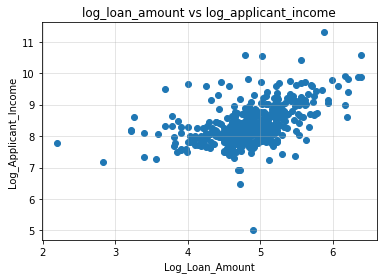

In [34]:
# from this plot, we can see that there exists high correlation:
plt.scatter(np.log(no_null_copy_data['LoanAmount']), np.log(no_null_copy_data['ApplicantIncome']))
plt.xlabel('Log_Loan_Amount', fontsize=10)
plt.ylabel('Log_Applicant_Income', fontsize=10)
plt.title('log_loan_amount vs log_applicant_income', fontsize=12)
plt.grid(True, alpha=0.4)

<p>Since, high correlation could be observed from the above plot, we can draw a<strong> Linear Regression Model </strong>with just one feature i.e. 'log_applicant_income'.</p>

                                 OLS Regression Results                                
Dep. Variable:        log_loan_amount   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                          5.023e+04
Date:                Tue, 05 Oct 2021   Prob (F-statistic):                        0.00
Time:                        15:07:26   Log-Likelihood:                         -287.81
No. Observations:                 450   AIC:                                      577.6
Df Residuals:                     449   BIC:                                      581.7
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

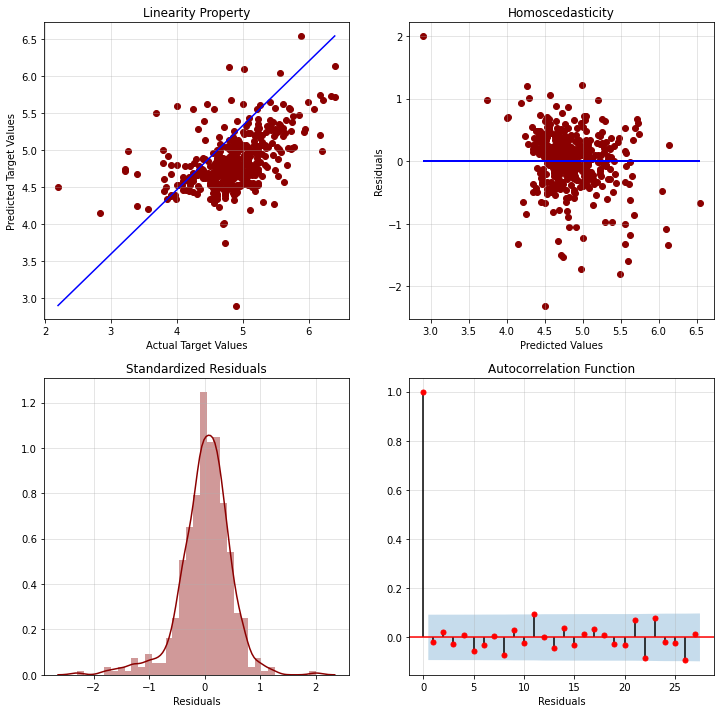

In [35]:
# modelling Linear Regression to predict 'log_loan_ampunt';
data_to_model = no_null_copy_data[['LoanAmount', 'ApplicantIncome']]
data_to_model['log_loan_amount'] = np.log(data_to_model['LoanAmount'])
data_to_model['log_applicant_income'] = np.log(data_to_model['ApplicantIncome'])
data_to_model = data_to_model.drop(['LoanAmount', 'ApplicantIncome'], axis=1)

# Creating Training and Validation Data:
x_train = data_to_model['log_applicant_income'][:450]
y_train = data_to_model['log_loan_amount'][:450]

# Validation Data:
x_val = data_to_model['log_applicant_income'][450:]
y_val = data_to_model['log_loan_amount'][450:]

# test data:
test_data = np.log(temp_data[temp_data['LoanAmount'].isnull()]['ApplicantIncome'])

final_model = train_linear_regression_model(x_train, y_train, x_val, y_val)
missing_values = np.exp(final_model.predict(test_data))
temp_data = attach_missing_values('LoanAmount', missing_values, temp_data=temp_data)

<h3>Observations of Model Constructed using Log-Applicant-Income:</h3>
<p>
<ol>
    <li>R-Squared is very good i.e.0.99. Model is significant, independent feature is also significant and Durbin Watson Test value also lies within the expected range i.e. 1.6 to 2.3.</li>
    <li>Residuals are normally distributed, autocorrelation function of residuals also seems to be significat i.e. errors are not correlated and to a larger extent, homoscedasticity also exists.</li>
    <li>Overall the assumptions of Linear Regression are verified and thus, we would predict the values of 'LoanAmount' using 'log_applicant_income'.</li>
    <li>Linearity can also be observed.</li>
   </ol>
</p>

The feature is nothin but a target feature itself
Final Selected Important Features:  ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome']
                            OLS Regression Results                            
Dep. Variable:             LoanAmount   R-squared:                       0.372
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     28.97
Date:                Tue, 05 Oct 2021   Prob (F-statistic):           1.58e-39
Time:                        15:07:27   Log-Likelihood:                -2506.1
No. Observations:                 450   AIC:                             5032.
Df Residuals:                     440   BIC:                             5073.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,Male,Yes,1,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y
5,Male,Yes,2,Graduate,Yes,5417,4196.0,267.000000,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
551,Male,Yes,1,Not Graduate,No,2492,2375.0,92.694497,360.0,1.0,Rural,Y
605,Male,Yes,0,Not Graduate,No,2400,3800.0,90.696968,180.0,1.0,Urban,N
102,Male,Yes,0,Graduate,No,13650,0.0,248.194910,360.0,1.0,Urban,Y
435,Female,No,0,Graduate,No,10047,0.0,207.831995,240.0,1.0,Semiurban,Y


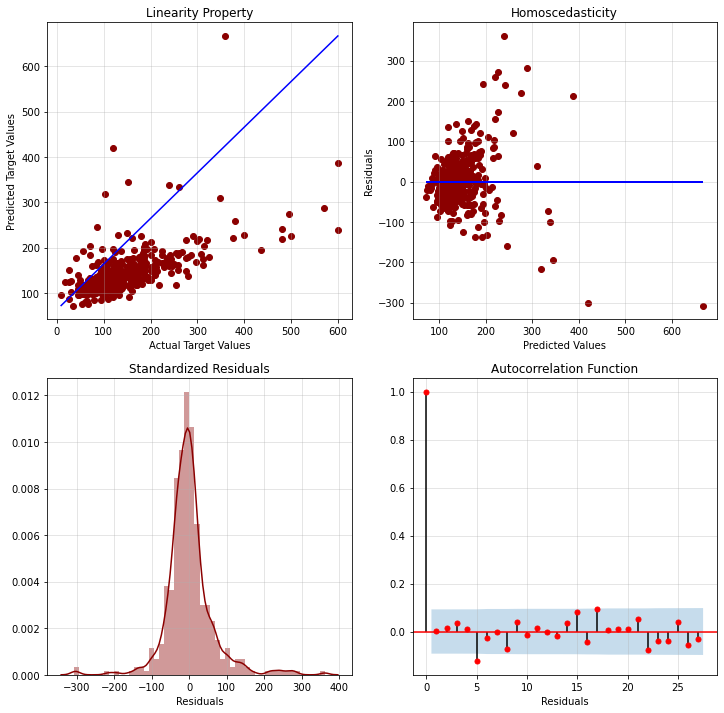

In [37]:
# if I consider all of the features which seem to be significant:
analysing_and_predicting_missing_num_values(no_null_copy_data, 'LoanAmount', temp_data)

<h3>Observation of Model Constructed Considering all Significant Features:</h3>
<p>
<ol>
    <li>R-squared and Adj-RSquared are really low i.e. around 0.36.</li>
    <li>The assumptions do not seem to be verified except that of the 'AutoCorrelation'.</li>
  </ol>
</p>

In [41]:
# no missing values for 'Loanamount'
temp_data.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

Now, no missing value is present and hence, we have finally dealt with all of the missing values.

In [42]:
# saving this data for future training purposes:
temp_data.to_csv('Final_Loan_Data.csv')

<h3>Observation:</h3>
<p>
<ol>
    <li></li>
    <li></li>
    <li></li>
    <li></li>
    <li></li>
    <li></li>
    </ol>
</p>